# **SpaceX  Falcon 9 First Stage Landing Prediction**

In this assignment, we will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is due to the fact that SpaceX can reuse the first stage.

In this lab, you will perform Exploratory Data Analysis and Feature Engineering.

Falcon 9 first stage will land successfully

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)

Several examples of an unsuccessful landing are shown here:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)

Most unsuccessful landings are planned. Space X performs a controlled landing in the oceans.


In [55]:
import requests
import json
import pandas as pd
import numpy as np
import datetime
from sqlalchemy import create_engine, text
import csv, sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon
#from js import fetch
import io
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#collect data from SpaceX API
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    with open('spacex_launches.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)
else:
    print(f"Failed to retrieve data: {response.status_code}")

In [10]:
data = pd.json_normalize(response.json())

In [11]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])


In [12]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [13]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [16]:
getBoosterVersion(data)
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [17]:
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


In [18]:
launch_df = pd.DataFrame(launch_dict)
print(launch_df.head())

   FlightNumber        Date BoosterVersion  PayloadMass Orbit  \
0             1  2006-03-24       Falcon 1         20.0   LEO   
1             2  2007-03-21       Falcon 1          NaN   LEO   
2             4  2008-09-28       Falcon 1        165.0   LEO   
3             5  2009-07-13       Falcon 1        200.0   LEO   
4             6  2010-06-04       Falcon 9          NaN   LEO   

        LaunchSite    Outcome  Flights  GridFins  Reused   Legs LandingPad  \
0  Kwajalein Atoll  None None        1     False   False  False       None   
1  Kwajalein Atoll  None None        1     False   False  False       None   
2  Kwajalein Atoll  None None        1     False   False  False       None   
3  Kwajalein Atoll  None None        1     False   False  False       None   
4     CCSFS SLC 40  None None        1     False   False  False       None   

   Block  ReusedCount    Serial   Longitude   Latitude  
0    NaN            0  Merlin1A  167.743129   9.047721  
1    NaN            0  Mer

In [19]:
data_falcon9 = launch_df[launch_df['BoosterVersion'] == 'Falcon 9']
print(data_falcon9.head())

   FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
4             6  2010-06-04       Falcon 9          NaN   LEO  CCSFS SLC 40   
5             8  2012-05-22       Falcon 9        525.0   LEO  CCSFS SLC 40   
6            10  2013-03-01       Falcon 9        677.0   ISS  CCSFS SLC 40   
7            11  2013-09-29       Falcon 9        500.0    PO   VAFB SLC 4E   
8            12  2013-12-03       Falcon 9       3170.0   GTO  CCSFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
4    None None        1     False   False  False       None    1.0   
5    None None        1     False   False  False       None    1.0   
6    None None        1     False   False  False       None    1.0   
7  False Ocean        1     False   False  False       None    1.0   
8    None None        1     False   False  False       None    1.0   

   ReusedCount Serial   Longitude   Latitude  
4            0  B0003  -80.577366  28.561857  
5         

In [20]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


In [23]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [22]:
# Calculate the mean for the PayloadMass
mean_payload_mass = data_falcon9['PayloadMass'].mean()

# Replace np.nan values in the PayloadMass column with the calculated mean
data_falcon9['PayloadMass'].replace(np.nan, mean_payload_mass, inplace=True)

# Display the updated dataframe
print(data_falcon9.head())

   FlightNumber        Date BoosterVersion  PayloadMass Orbit    LaunchSite  \
4             1  2010-06-04       Falcon 9  6123.547647   LEO  CCSFS SLC 40   
5             2  2012-05-22       Falcon 9   525.000000   LEO  CCSFS SLC 40   
6             3  2013-03-01       Falcon 9   677.000000   ISS  CCSFS SLC 40   
7             4  2013-09-29       Falcon 9   500.000000    PO   VAFB SLC 4E   
8             5  2013-12-03       Falcon 9  3170.000000   GTO  CCSFS SLC 40   

       Outcome  Flights  GridFins  Reused   Legs LandingPad  Block  \
4    None None        1     False   False  False       None    1.0   
5    None None        1     False   False  False       None    1.0   
6    None None        1     False   False  False       None    1.0   
7  False Ocean        1     False   False  False       None    1.0   
8    None None        1     False   False  False       None    1.0   

   ReusedCount Serial   Longitude   Latitude  
4            0  B0003  -80.577366  28.561857  
5         

/var/folders/gs/yllxycxn6m72l4z4l69nj54r0000gn/T/ipykernel_74335/175251893.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_falcon9['PayloadMass'].replace(np.nan, mean_payload_mass, inplace=True)
/var/folders/gs/yllxycxn6m72l4z4l69nj54r0000gn/T/ipykernel_74335/175251893.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['

In [24]:
data_falcon9.isnull().sum()
data_falcon9.to_csv('dataset_part_1.csv', index=False)

In [26]:
data_falcon9.isnull().sum()/len(data_falcon9)*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

In [27]:
data_falcon9.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [28]:
launch_site_counts = data_falcon9['LaunchSite'].value_counts()
print(launch_site_counts)

LaunchSite
CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64


In [29]:
orbit_counts = data_falcon9['Orbit'].value_counts()
print(orbit_counts)

Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: count, dtype: int64


In [30]:
landing_outcomes = data_falcon9['Outcome'].value_counts()
print(landing_outcomes)

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64


<code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully  landed to a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed to a drone ship. <code>None ASDS</code> and <code>None None</code> these represent a failure to land.

In [31]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [32]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [35]:
landing_class = [0 if outcome in bad_outcomes else 1 for outcome in Outcome]
landing_class[:5]

[0, 0, 0, 0, 0]

In [40]:
# Filter landing_class to match the indices of data_falcon9
filtered_landing_class = [landing_class[i] for i in data_falcon9.index]

# Assign the filtered landing_class to the data_falcon9 DataFrame
data_falcon9['Class'] = filtered_landing_class
data_falcon9[['Class']].head(8)

/var/folders/gs/yllxycxn6m72l4z4l69nj54r0000gn/T/ipykernel_74335/1794581882.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Class'] = filtered_landing_class


,Class
4,0
5,0
6,0
7,0
8,0
9,0
10,1
11,1


In [42]:
data_falcon9.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


In [43]:
data_falcon9["Class"].mean()

0.6666666666666666

In [44]:
data_falcon9.to_csv("dataset_part_2.csv", index=False)

<h1 align=center><font size = 5>Assignment: SQL Notebook for Peer Assignment</font></h1>

## Introduction
Using this Python notebook you will:

1.  Understand the Spacex DataSet
2.  Load the dataset  into the corresponding table in a Db2 database
3.  Execute SQL queries to answer assignment questions 


In [ ]:
!pip install sqlalchemy==1.3.9
!pip install ipython-sql
!pip install -q pandas
%load_ext sql


con = sqlite3.connect("my_data1.db")
cur = con.cursor()
%sql sqlite:///my_data1.db

  Using cached SQLAlchemy-1.3.9-cp39-cp39-macosx_14_0_arm64.whl
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.3.9 which is incompatible.

[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached SQLAlchemy-2.0.36-cp39-cp39-macosx_11_0_arm64.whl.metadata (9.7 kB)
Using cached SQLAlchemy-2.0.36-cp39-cp39-macosx_11_0_arm64.whl (2.1 MB)
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.3.9
    Uninstalling SQLAlchemy-1.3.9:
      Successfully uninstalled SQLAlchemy-1.3.9

[notice] A new release of pip is available: 24.1.1 -> 24

In [74]:
from sqlalchemy import create_engine, text

# Step 1: Create a database engine for SQLite
engine = create_engine("sqlite:///my_data1.db")

# Step 2: Read CSV and create SPACEXTBL
df = pd.read_csv("Spacex.csv")
df.to_sql("SPACEXTBL", con=engine, if_exists='replace', index=False, method="multi")

# Step 3: Drop SPACEXTABLE if it exists
with engine.connect() as conn:
    conn.execute(text("DROP TABLE IF EXISTS SPACEXTABLE"))

# Step 4: Create SPACEXTABLE with a filter
with engine.connect() as conn:
    conn.execute(text("CREATE TABLE SPACEXTABLE AS SELECT * FROM SPACEXTBL WHERE Date IS NOT NULL"))

In [78]:
with engine.connect() as conn:
    result = conn.execute(text("SELECT * FROM SPACEXTABLE WHERE Launch_Site LIKE 'CCA%' LIMIT 5"))
    rows = result.fetchall()  # Fetch all results

    # Display the results
    for row in rows:
        print(row)

('2010-06-04', '18:45:00', 'F9 v1.0  B0003', 'CCAFS LC-40', 'Dragon Spacecraft Qualification Unit', 0, 'LEO', 'SpaceX', 'Success', 'Failure (parachute)')
('2010-12-08', '15:43:00', 'F9 v1.0  B0004', 'CCAFS LC-40', 'Dragon demo flight C1, two CubeSats, barrel of Brouere cheese', 0, 'LEO (ISS)', 'NASA (COTS) NRO', 'Success', 'Failure (parachute)')
('2012-05-22', '7:44:00', 'F9 v1.0  B0005', 'CCAFS LC-40', 'Dragon demo flight C2', 525, 'LEO (ISS)', 'NASA (COTS)', 'Success', 'No attempt')
('2012-10-08', '0:35:00', 'F9 v1.0  B0006', 'CCAFS LC-40', 'SpaceX CRS-1', 500, 'LEO (ISS)', 'NASA (CRS)', 'Success', 'No attempt')
('2013-03-01', '15:10:00', 'F9 v1.0  B0007', 'CCAFS LC-40', 'SpaceX CRS-2', 677, 'LEO (ISS)', 'NASA (CRS)', 'Success', 'No attempt')


In [81]:
with engine.connect() as conn:
    # Execute the query and fetch the result
    result = conn.execute(text("SELECT SUM(PAYLOAD_MASS__KG_) AS Total_Payload_Mass FROM SPACEXTABLE WHERE Customer = 'NASA (CRS)'"))
    rows = result.fetchall()  # Fetch all results

    # Display the results
    for row in rows:
        print(row)

(45596,)


In [82]:
with engine.connect() as conn:
    # Execute the query and fetch the result
    result = conn.execute(text("SELECT AVG(PAYLOAD_MASS__KG_) AS Average_Payload_Mass FROM SPACEXTABLE WHERE Booster_Version = 'F9 v1.1'"))
    rows = result.fetchall()  # Fetch all results

    # Display the results
    for row in rows:
        print(row)

(2928.4,)


In [85]:
with engine.connect() as conn:
    # Execute the query and fetch the result
    result = conn.execute(text("SELECT MIN(Date) AS First_Successful_Landing_Date FROM SPACEXTABLE WHERE Landing_Outcome = 'Success (ground pad)'"))
    rows = result.fetchall()  # Fetch all results

    # Display the results
    for row in rows:
        print(row)

('2015-12-22',)


In [87]:
with engine.connect() as conn:
    # Execute the query and fetch the result
    result = conn.execute(text("""
        SELECT Booster_Version
        FROM SPACEXTABLE
        WHERE Landing_Outcome = 'Success (drone ship)'
          AND PAYLOAD_MASS__KG_ > 4000
          AND PAYLOAD_MASS__KG_ < 6000
    """))
    rows = result.fetchall()  # Fetch all results

    # Display the results
    for row in rows:
        print(row)

('F9 FT B1022',)
('F9 FT B1026',)
('F9 FT  B1021.2',)
('F9 FT  B1031.2',)


In [88]:
with engine.connect() as conn:
    # Execute the query and fetch the result
    result = conn.execute(text("SELECT Landing_Outcome, COUNT(*) AS Total_Count FROM SPACEXTABLE GROUP BY Landing_Outcome"))
    rows = result.fetchall()  # Fetch all results

    # Display the results
    for row in rows:
        print(row)

('Controlled (ocean)', 5)
('Failure', 3)
('Failure (drone ship)', 5)
('Failure (parachute)', 2)
('No attempt', 21)
('No attempt ', 1)
('Precluded (drone ship)', 1)
('Success', 38)
('Success (drone ship)', 14)
('Success (ground pad)', 9)
('Uncontrolled (ocean)', 2)


In [90]:
with engine.connect() as conn:
    # Execute the query and fetch the result
    result = conn.execute(text("""
        SELECT Booster_Version 
        FROM SPACEXTABLE 
        WHERE PAYLOAD_MASS__KG_ = (SELECT MAX(PAYLOAD_MASS__KG_) FROM SPACEXTABLE)
    """))
    rows = result.fetchall()  # Fetch all results

    # Display the results
    for row in rows:
        print(row)

('F9 B5 B1048.4',)
('F9 B5 B1049.4',)
('F9 B5 B1051.3',)
('F9 B5 B1056.4',)
('F9 B5 B1048.5',)
('F9 B5 B1051.4',)
('F9 B5 B1049.5',)
('F9 B5 B1060.2 ',)
('F9 B5 B1058.3 ',)
('F9 B5 B1051.6',)
('F9 B5 B1060.3',)
('F9 B5 B1049.7 ',)


In [91]:
with engine.connect() as conn:
    # Execute the query and fetch the result
    result = conn.execute(text("""
        SELECT 
            CASE substr(Date, 6, 2)
                WHEN '01' THEN 'January'
                WHEN '02' THEN 'February'
                WHEN '03' THEN 'March'
                WHEN '04' THEN 'April'
                WHEN '05' THEN 'May'
                WHEN '06' THEN 'June'
                WHEN '07' THEN 'July'
                WHEN '08' THEN 'August'
                WHEN '09' THEN 'September'
                WHEN '10' THEN 'October'
                WHEN '11' THEN 'November'
                WHEN '12' THEN 'December'
            END AS Month,
            Landing_Outcome,
            Booster_Version,
            Launch_Site
        FROM SPACEXTABLE
        WHERE Landing_Outcome = 'Failure (drone ship)'
          AND substr(Date, 0, 5) = '2015'
    """))
    rows = result.fetchall()  # Fetch all results

    # Display the results
    for row in rows:
        print(row)

('January', 'Failure (drone ship)', 'F9 v1.1 B1012', 'CCAFS LC-40')
('April', 'Failure (drone ship)', 'F9 v1.1 B1015', 'CCAFS LC-40')


In [92]:
with engine.connect() as conn:
    # Execute the query and fetch the result
    result = conn.execute(text("""
        SELECT 
            Landing_Outcome,
            COUNT(*) AS Outcome_Count
        FROM SPACEXTABLE
        WHERE Date BETWEEN '2010-06-04' AND '2017-03-20'
        GROUP BY Landing_Outcome
        ORDER BY Outcome_Count DESC
    """))
    rows = result.fetchall()  # Fetch all results

    # Display the results
    for row in rows:
        print(row)

('No attempt', 10)
('Success (drone ship)', 5)
('Failure (drone ship)', 5)
('Success (ground pad)', 3)
('Controlled (ocean)', 3)
('Uncontrolled (ocean)', 2)
('Failure (parachute)', 2)
('Precluded (drone ship)', 1)


## Objectives

Perform exploratory Data Analysis and Feature Engineering using `Pandas` and `Matplotlib`

*   Exploratory Data Analysis
*   Preparing Data  Feature Engineering

In [98]:
df=pd.read_csv("dataset_part_2.csv")
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


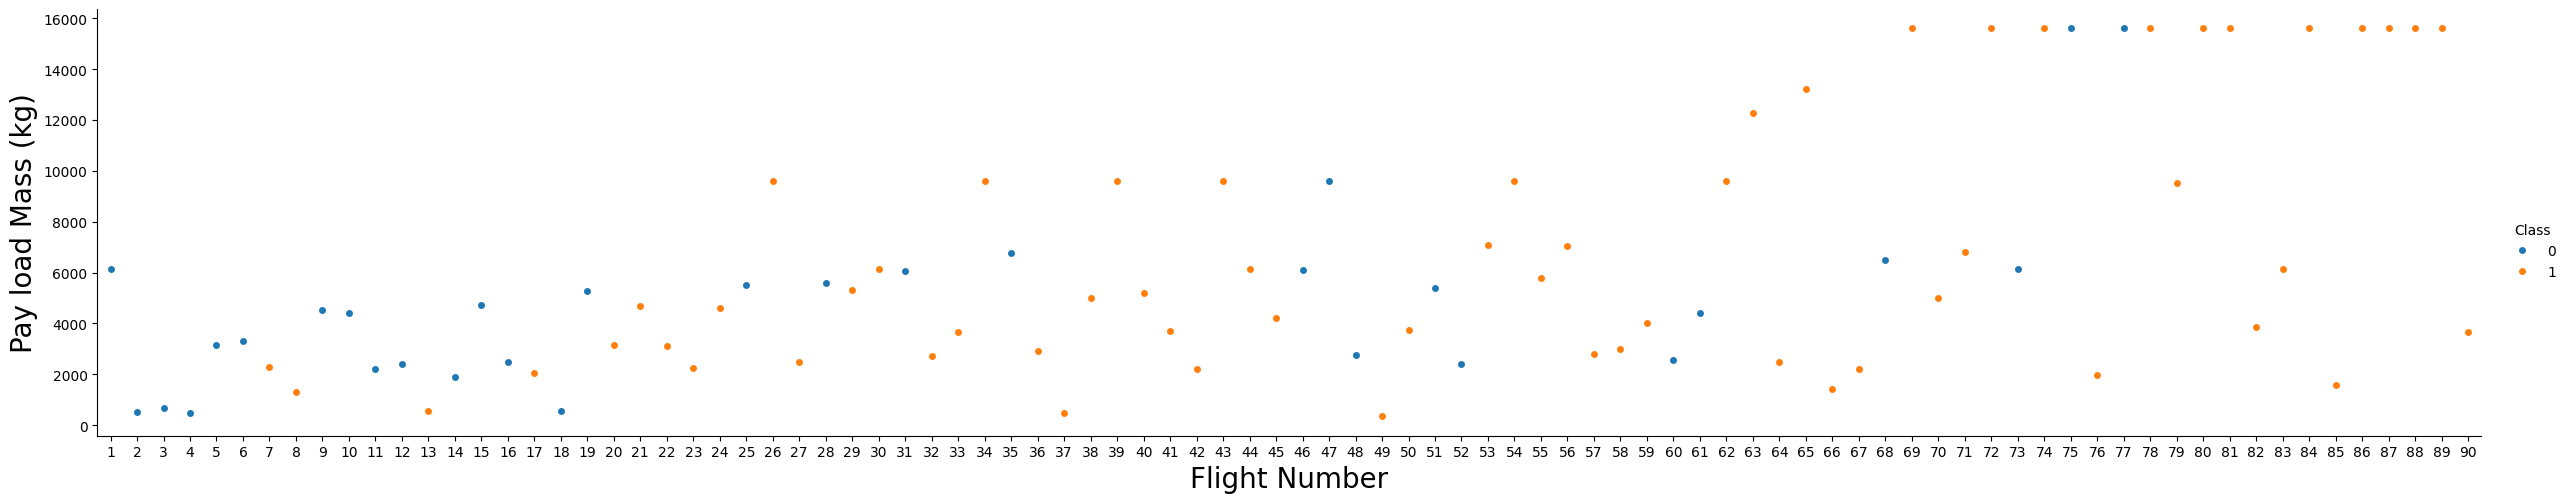

In [99]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

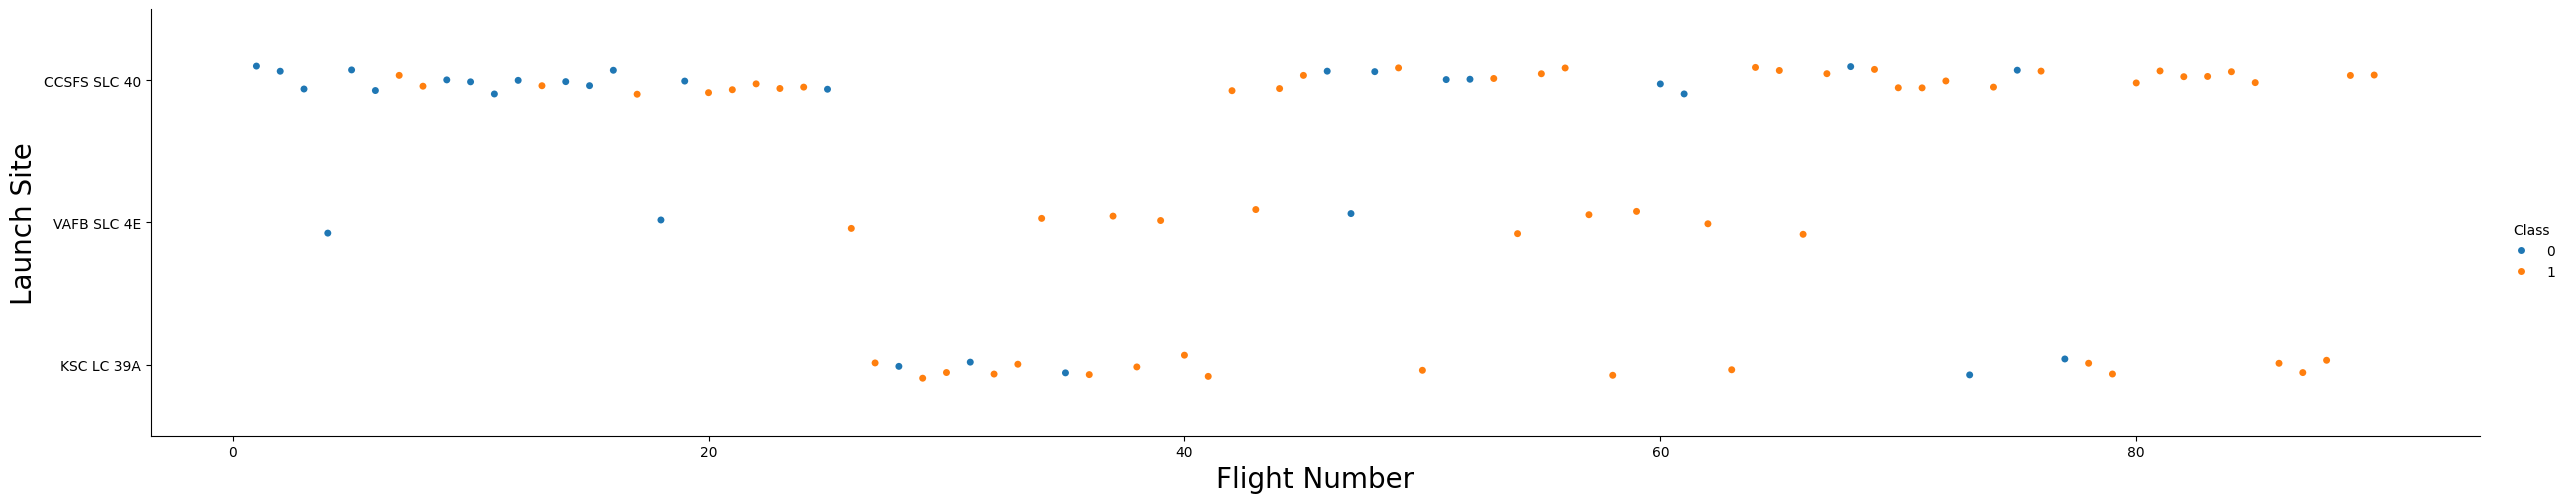

In [100]:
sns.catplot(x="FlightNumber", y="LaunchSite", hue="Class", data=df, aspect=5)
plt.xlabel("Flight Number", fontsize=20)
plt.ylabel("Launch Site", fontsize=20)
plt.show()

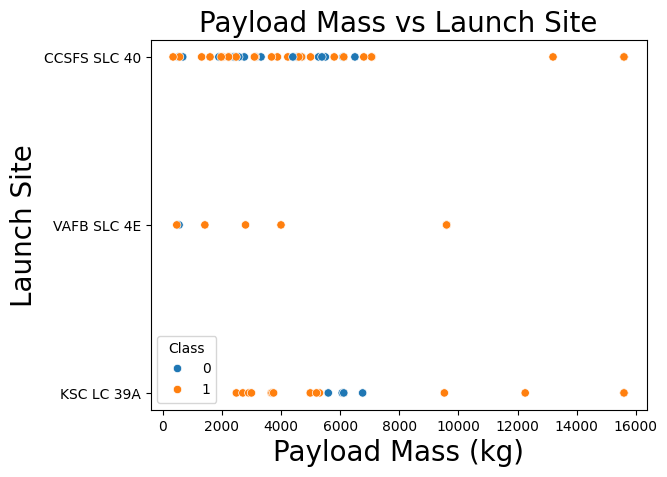

In [102]:
sns.scatterplot(x="PayloadMass", y="LaunchSite", hue="Class", data=df)
plt.xlabel("Payload Mass (kg)", fontsize=20)
plt.ylabel("Launch Site", fontsize=20)
plt.title("Payload Mass vs Launch Site", fontsize=20)
plt.show()

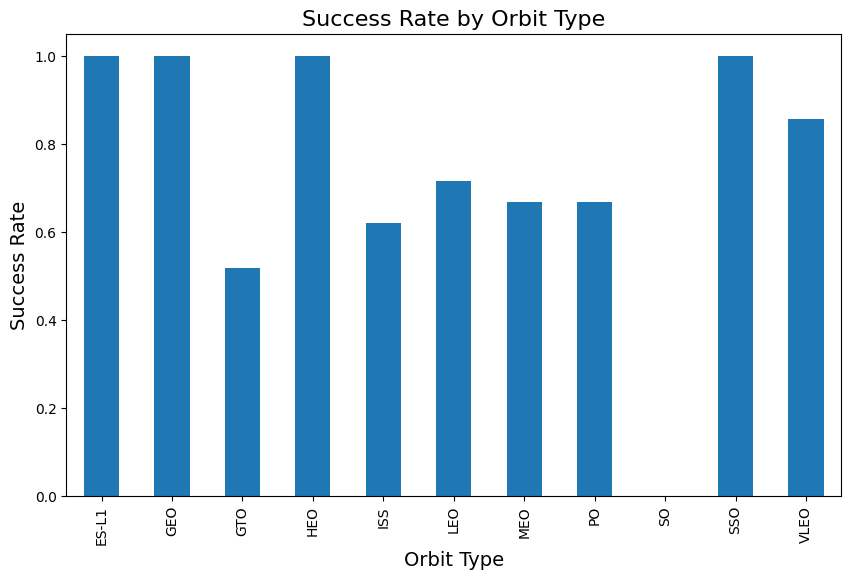

In [103]:
# Group by Orbit and calculate the mean of Class
orbit_success_rate = df.groupby('Orbit')['Class'].mean()

# Plotting the bar chart
orbit_success_rate.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Orbit Type', fontsize=14)
plt.ylabel('Success Rate', fontsize=14)
plt.title('Success Rate by Orbit Type', fontsize=16)
plt.show()

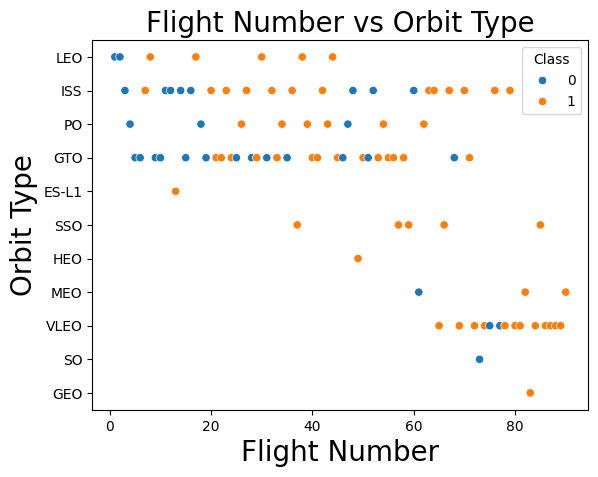

In [104]:
sns.scatterplot(x="FlightNumber", y="Orbit", hue="Class", data=df)
plt.xlabel("Flight Number", fontsize=20)
plt.ylabel("Orbit Type", fontsize=20)
plt.title("Flight Number vs Orbit Type", fontsize=20)
plt.show()

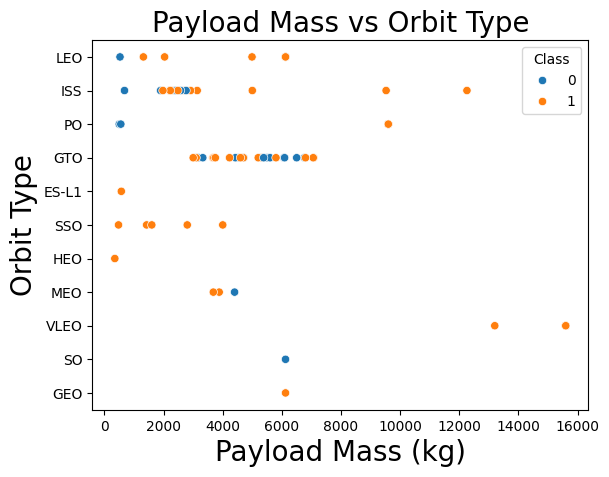

In [105]:
sns.scatterplot(x="PayloadMass", y="Orbit", hue="Class", data=df)
plt.xlabel("Payload Mass (kg)", fontsize=20)
plt.ylabel("Orbit Type", fontsize=20)
plt.title("Payload Mass vs Orbit Type", fontsize=20)
plt.show()

In [107]:
year=[]
def Extract_year():
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year
Extract_year()
df['Date'] = year
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


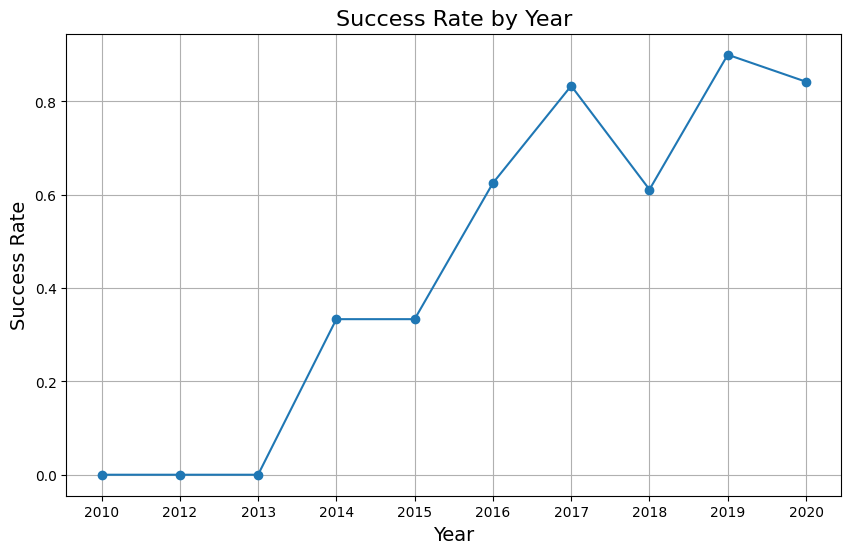

In [108]:
# Calculate the success rate by year
success_rate_by_year = df.groupby('Date')['Class'].mean()

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(success_rate_by_year.index, success_rate_by_year.values, marker='o')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Success Rate', fontsize=14)
plt.title('Success Rate by Year', fontsize=16)
plt.grid(True)
plt.show()

In [109]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


In [110]:
# Apply OneHotEncoder to the specified columns
features_one_hot = pd.get_dummies(features, columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])

# Display the results
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6123.547647,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,525.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,677.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,500.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,3170.000000,1,False,False,False,1.0,0,False,False,...,False,False,False,False,False,False,False,False,False,False


In [111]:
features_one_hot = features_one_hot.astype('float64')
features_one_hot.dtypes

FlightNumber    float64
PayloadMass     float64
Flights         float64
GridFins        float64
Reused          float64
                 ...   
Serial_B1056    float64
Serial_B1058    float64
Serial_B1059    float64
Serial_B1060    float64
Serial_B1062    float64
Length: 80, dtype: object

In [112]:
features_one_hot.to_csv('dataset_part_3.csv', index=False)

In [113]:
# Apply OneHotEncoder to the specified columns
features_one_hot = pd.get_dummies(features, columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])

# Get the total number of columns
total_columns = features_one_hot.shape[1]
total_columns

80

## Objectives
This lab contains the following tasks:

*   **TASK 1:** Mark all launch sites on a map
*   **TASK 2:** Mark the success/failed launches for each site on the map
*   **TASK 3:** Calculate the distances between a launch site to its proximities

After completed the above tasks, you should be able to find some geographical patterns about launch sites.


In [ ]:
#spacex_csv_file = io.BytesIO((await resp.arrayBuffer()).to_py())
spacex_df=pd.read_csv('spacex_launch_geo.csv')
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


In [16]:
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

# Add a marker for each launch site
for index, site in launch_sites_df.iterrows():
    # Create a circle for each launch site
    folium.Circle(
        location=[site['Lat'], site['Long']],
        radius=1000,
        color='#d35400',
        fill=True
    ).add_to(site_map)

    # Create a marker for each launch site
    folium.map.Marker(
        [site['Lat'], site['Long']],
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % site['Launch Site'],
        )
    ).add_to(site_map)

# Define coordinates for the equator and tropics lines
equator = [[0, -180], [0, 180]]
tropic_of_cancer = [[23.4366, -180], [23.4366, 180]]
tropic_of_capricorn = [[-23.4366, -180], [-23.4366, 180]]

# Add the equator and tropics lines to the map
folium.PolyLine(equator, color='blue', weight=2.5, opacity=1).add_to(site_map)
folium.PolyLine(tropic_of_cancer, color='green', weight=2.5, opacity=1).add_to(site_map)
folium.PolyLine(tropic_of_capricorn, color='green', weight=2.5, opacity=1).add_to(site_map)

# Add labels for the equator and tropics
folium.Marker(
    [0, 0],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:blue;"><b>Equator</b></div>',
    )
).add_to(site_map)

folium.Marker(
    [23.4366, 0],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:green;"><b>Tropic of Cancer</b></div>',
    )
).add_to(site_map)

folium.Marker(
    [-23.4366, 0],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:green;"><b>Tropic of Capricorn</b></div>',
    )
).add_to(site_map)

# Add markers for launch outcomes
for index, launch in spacex_df.iterrows():
    # Determine the color based on the launch outcome
    color = 'green' if launch['class'] == 1 else 'red'
    
    # Add a marker for each launch
    folium.Circle(
        location=[launch['Lat'], launch['Long']],
        radius=100,
        color=color,
        fill=True,
        fill_color=color
    ).add_to(site_map)

# Display the map
site_map

In [17]:
spacex_df.tail(10)

,Launch Site,Lat,Long,class
46,KSC LC-39A,28.573255,-80.646895,1
47,KSC LC-39A,28.573255,-80.646895,1
48,KSC LC-39A,28.573255,-80.646895,1
49,CCAFS SLC-40,28.563197,-80.576820,1
50,CCAFS SLC-40,28.563197,-80.576820,1
51,CCAFS SLC-40,28.563197,-80.576820,0
52,CCAFS SLC-40,28.563197,-80.576820,0
53,CCAFS SLC-40,28.563197,-80.576820,0
54,CCAFS SLC-40,28.563197,-80.576820,1
55,CCAFS SLC-40,28.563197,-80.576820,0


In [18]:
marker_cluster = MarkerCluster()

In [32]:
# Define a function to determine the marker color based on the class value
def get_marker_color(launch_class):
    return 'green' if launch_class == 1 else 'red'

# Apply the function to create the marker_color column
spacex_df['marker_color'] = spacex_df['class'].apply(get_marker_color)

# Display the updated dataframe
spacex_df.head()

,Launch Site,Lat,Long,class,marker_color
0,CCAFS LC-40,28.562302,-80.577356,0,red
1,CCAFS LC-40,28.562302,-80.577356,0,red
2,CCAFS LC-40,28.562302,-80.577356,0,red
3,CCAFS LC-40,28.562302,-80.577356,0,red
4,CCAFS LC-40,28.562302,-80.577356,0,red


In [33]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

In [ ]:
# Function to calculate the distance between two points using the Haversine formula
def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

# Coordinates of the closest coastline point (example coordinates)
coastline_lat = 28.56381
coastline_lon = -80.56807

# Coordinates of the launch site (example coordinates)
launch_site_lat = 28.563197
launch_site_lon = -80.576820

# Calculate the distance between the launch site and the coastline
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)

# Create and add a folium.Marker on the selected closest coastline point on the map
distance_marker = folium.Marker(
    [coastline_lat, coastline_lon],
    icon=DivIcon(
        icon_size=(20, 20),
        icon_anchor=(0, 0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline),
    )
)

# Add the marker to the site map
site_map.add_child(distance_marker)

# Draw a line between the launch site and the coastline
folium.PolyLine(
    locations=[[launch_site_lat, launch_site_lon], [coastline_lat, coastline_lon]],
    color='blue',
    weight=2.5,
    opacity=1
).add_to(site_map)

# Coordinates for the closest city, railway, and highway
railroad_lat = 28.52411
railroad_lon = -80.78962

highway_lat = 28.55765
highway_lon = -80.82237

city_lat = 28.61248
city_lon = -80.80856

# Calculate distances
distance_railroad = calculate_distance(launch_site_lat, launch_site_lon, railroad_lat, railroad_lon)
distance_highway = calculate_distance(launch_site_lat, launch_site_lon, highway_lat, highway_lon)
distance_city = calculate_distance(launch_site_lat, launch_site_lon, city_lat, city_lon)

# Draw lines and add markers with distance labels
folium.PolyLine(
    locations=[[launch_site_lat, launch_site_lon], [railroad_lat, railroad_lon]],
    color='black',
    weight=2.5,
    opacity=1
).add_to(site_map)

folium.Marker(
    [railroad_lat, railroad_lon],
    icon=DivIcon(
        icon_size=(20, 20),
        icon_anchor=(0, 0),
        html='<div style="font-size: 12; color:black;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_railroad),
    )
).add_to(site_map)

folium.PolyLine(
    locations=[[launch_site_lat, launch_site_lon], [highway_lat, highway_lon]],
    color='green',
    weight=2.5,
    opacity=1
).add_to(site_map)

folium.Marker(
    [highway_lat, highway_lon],
    icon=DivIcon(
        icon_size=(20, 20),
        icon_anchor=(0, 0),
        html='<div style="font-size: 12; color:green;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_highway),
    )
).add_to(site_map)

folium.PolyLine(
    locations=[[launch_site_lat, launch_site_lon], [city_lat, city_lon]],
    color='red',
    weight=2.5,
    opacity=1
).add_to(site_map)

folium.Marker(
    [city_lat, city_lon],
    icon=DivIcon(
        icon_size=(20, 20),
        icon_anchor=(0, 0),
        html='<div style="font-size: 12; color:red;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_city),
    )
).add_to(site_map)

# Display the map
site_map

In [26]:
# Define the coordinates for the polyline
coordinates = [[launch_site_lat, launch_site_lon], [coastline_lat, coastline_lon]]

# Create a folium.PolyLine object
lines = folium.PolyLine(locations=coordinates, weight=1)

# Add the polyline to the map
site_map.add_child(lines)

# Display the map
site_map

## Objectives

Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data

In [35]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

In [ ]:
data = pd.read_csv('dataset_part_2.csv')
X = pd.read_csv('dataset_part_3.csv')
data.head()
X.head(100)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [39]:
Y = data['Class'].to_numpy()

In [40]:
transform = preprocessing.StandardScaler()

In [41]:
X = transform.fit_transform(X)

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [43]:
Y_test.shape

(18,)

In [44]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [46]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

In [48]:
logreg_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [49]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


In [50]:
accuracy = logreg_cv.score(X_test, Y_test)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.8333333333333334


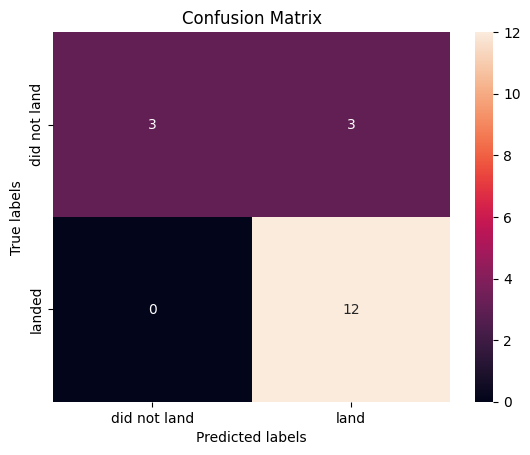

In [56]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [57]:
parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [2*n for n in range(1,10)],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

tree_cv = GridSearchCV(estimator=tree, param_grid=parameters, cv=10)
tree_cv.fit(X_train, Y_train)

print("Best parameters found: ", tree_cv.best_params_)
print("Best score: ", tree_cv.best_score_)

Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
Best score:  0.8767857142857144


C:\Users\cbarbosa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cbarbosa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cbarbosa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalC

In [58]:
accuracy_tree_cv = tree_cv.score(X_test, Y_test)
print("Accuracy of Decision Tree on test data:", accuracy_tree_cv)

Accuracy of Decision Tree on test data: 0.7222222222222222


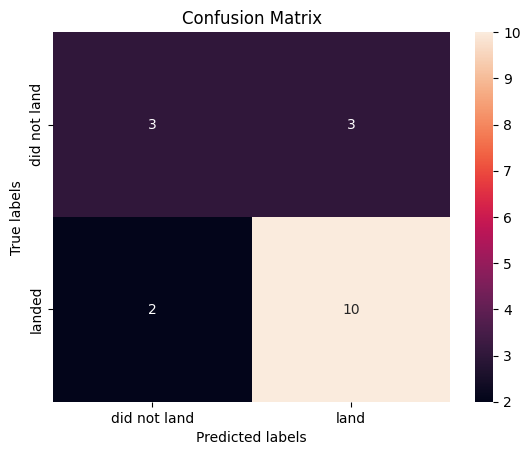

In [59]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [62]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}


In [63]:
# Create a k nearest neighbors object
knn = KNeighborsClassifier()

# Create a GridSearchCV object with cv=10
knn_cv = GridSearchCV(estimator=knn, param_grid=parameters, cv=10)

# Fit the object to find the best parameters
knn_cv.fit(X_train, Y_train)

# Print the best parameters and the best score
print("Best parameters found: ", knn_cv.best_params_)
print("Best score: ", knn_cv.best_score_)

Best parameters found:  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
Best score:  0.8339285714285714


In [64]:
accuracy_knn_cv = knn_cv.score(X_test, Y_test)
print("Accuracy of KNN on test data:", accuracy_knn_cv)

Accuracy of KNN on test data: 0.7777777777777778


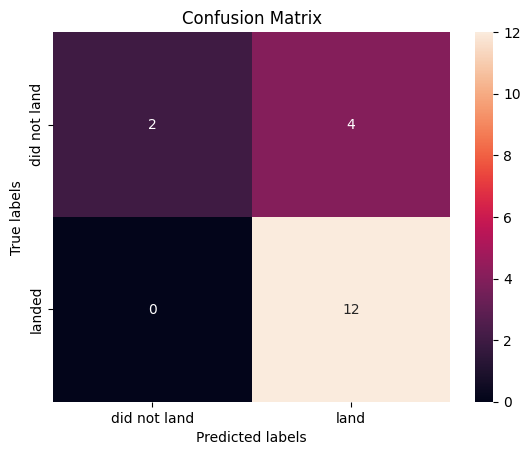

In [65]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [66]:
# Print the accuracies of the different models
print("Logistic Regression Accuracy:", accuracy)
print("Decision Tree Accuracy:", accuracy_tree_cv)
print("KNN Accuracy:", accuracy_knn_cv)

# Determine the best model based on accuracy
best_model = max((accuracy, "Logistic Regression"), (accuracy_tree_cv, "Decision Tree"), (accuracy_knn_cv, "KNN"))
print("Best Model:", best_model[1], "with accuracy:", best_model[0])

Logistic Regression Accuracy: 0.8333333333333334
Decision Tree Accuracy: 0.7222222222222222
KNN Accuracy: 0.7777777777777778
Best Model: Logistic Regression with accuracy: 0.8333333333333334
